In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

For each of the six rides, we have a separate csv file with wait time data. We need to merge & clean this data for comparison. 

In [44]:
seven=pd.read_csv('7_dwarfs_train.csv', delimiter = ',');
toy=pd.read_csv('toy_story_mania.csv', delimiter = ',');
rock=pd.read_csv('rock_n_rollercoaster.csv', delimiter = ',');
splash=pd.read_csv('splash_mountain.csv', delimiter = ',');
soarin=pd.read_csv('soarin.csv', delimiter = ',');
space=pd.read_csv('spaceship_earth.csv', delimiter = ',');

##rename columns so it's clear which time corresponds to which ride when merge data frames
seven=seven.rename(index=str, columns={"SPOSTMIN":"seven_dwarfs"})
toy=toy.rename(index=str, columns={"SPOSTMIN":"toy_story_mania"})
rock=rock.rename(index=str, columns={"SPOSTMIN":"rockin_rollercoaster"})
splash=splash.rename(index=str, columns={"SPOSTMIN":"splash_mountain"})
space=space.rename(index=str, columns={"SPOSTMIN":"space_earth"})
soarin=soarin.rename(index=str, columns={"SPOSTMIN":"soarin"})

In [45]:
##removing redundant columns
dframes=[toy,rock,seven,splash,space,soarin];
for df in dframes:
    df.drop(['SACTMIN','date'],inplace=True, axis=1)

In [46]:
##merge all 4 data frames (rides)

df= reduce(lambda  left,right: pd.merge(left,right,on=['datetime'],
                                            how='outer'), dframes)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16368606 entries, 0 to 16368605
Data columns (total 7 columns):
datetime                object
toy_story_mania         float64
rockin_rollercoaster    float64
seven_dwarfs            float64
splash_mountain         float64
space_earth             float64
soarin                  float64
dtypes: float64(6), object(1)
memory usage: 999.1+ MB


In [48]:
##set datetime index
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']

del df['datetime']


In [49]:
df.describe()

,toy_story_mania,rockin_rollercoaster,seven_dwarfs,splash_mountain,space_earth,soarin
count,1.587977e+07,1.587010e+07,1.573309e+07,1.544690e+07,1.588189e+07,1.588324e+07
mean,7.659975e+01,5.529635e+01,9.136243e+01,4.666478e+01,9.056647e+00,5.900409e+01
std,3.015983e+01,3.041879e+01,3.816940e+01,7.716193e+01,2.448780e+01,2.282144e+01
min,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02
25%,6.500000e+01,5.000000e+01,9.000000e+01,3.500000e+01,5.000000e+00,4.500000e+01
50%,8.500000e+01,6.000000e+01,9.000000e+01,5.000000e+01,5.000000e+00,6.000000e+01
75%,8.500000e+01,6.000000e+01,1.050000e+02,6.000000e+01,1.000000e+01,7.000000e+01
max,3.000000e+02,2.500000e+02,2.800000e+02,3.000000e+02,2.100000e+02,2.800000e+02


In [50]:
##some obvious outliers & corrupted data entry. The table above shows minimum wait times <0. The wait time should never be <0
df[(df<=0)] = np.nan

In [51]:
##remove duplicated entries
df = df[~df.index.duplicated(keep='first')]


In [52]:
##remove rows with all NA (timestamps at which no ride wait time was recorded)
df=df.dropna(how='all')
df = df.sort_index()


Set the beginning date for our analysis (when consistent recording of wait time for seven dwarfs began)

In [53]:
df=df['2014-05-23':]

Set the beginning time for our analysis to be the latest "first valid index" (i.e. the latest time one of the rides started recording on that date)

In [54]:
for col_name, data in df.items(): 
    print("First valid index for column {} is at {}".format(col_name, data.first_valid_index()))

First valid index for column toy_story_mania is at 2014-05-23 07:50:00
First valid index for column rockin_rollercoaster is at 2014-05-23 08:18:00
First valid index for column seven_dwarfs is at 2014-05-23 06:33:00
First valid index for column splash_mountain is at 2014-05-23 07:03:00
First valid index for column space_earth is at 2014-05-23 09:14:00
First valid index for column soarin is at 2014-05-23 09:14:00


In [55]:
df=df['2014-05-23 09:14:00':]
df.head()

,toy_story_mania,rockin_rollercoaster,seven_dwarfs,splash_mountain,space_earth,soarin
datetime,,,,,,
2014-05-23 09:14:00,50.0,30.0,NaN,10.0,5.0,45.0
2014-05-23 09:15:00,NaN,30.0,NaN,NaN,NaN,45.0
2014-05-23 09:27:00,NaN,NaN,60.0,NaN,NaN,NaN
2014-05-23 09:29:00,NaN,NaN,55.0,NaN,NaN,NaN
2014-05-23 09:37:00,NaN,30.0,NaN,NaN,NaN,NaN


Seven dwarfs is NaN @ 9:14, so we will set this value to 60 (the same as the first recorded value on this day). (Other NA values will be interpolated in later steps.)

In [56]:
df.seven_dwarfs['2014-05-23 09:14:00'] = 60
df['2014-05-23 09:14:00':].head()

,toy_story_mania,rockin_rollercoaster,seven_dwarfs,splash_mountain,space_earth,soarin
datetime,,,,,,
2014-05-23 09:14:00,50.0,30.0,60.0,10.0,5.0,45.0
2014-05-23 09:15:00,NaN,30.0,NaN,NaN,NaN,45.0
2014-05-23 09:27:00,NaN,NaN,60.0,NaN,NaN,NaN
2014-05-23 09:29:00,NaN,NaN,55.0,NaN,NaN,NaN
2014-05-23 09:37:00,NaN,30.0,NaN,NaN,NaN,NaN


It's clear that we have missing data due to the different times at which the wait time was recorded across different rides. However, since the time of recording is close, we can interpolate the missing values using the last recorded time. 

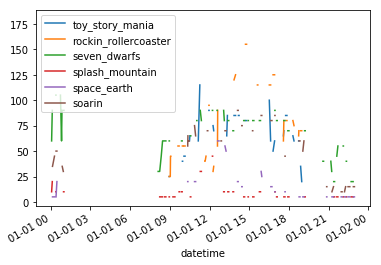

In [57]:
##visualize missing data on single date
fig, ax = plt.subplots()
for column in df:
    df['2018-01-01'][column].plot(ax=ax, label=column)
ax.legend()
plt.show()

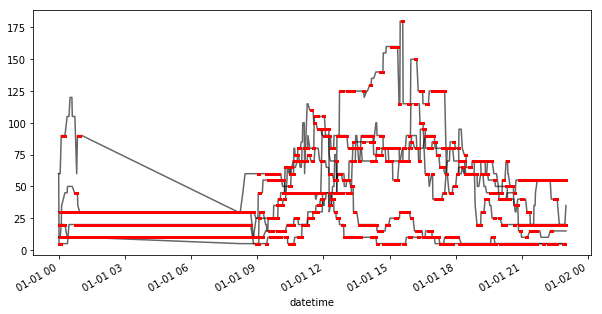

In [58]:
  # Create a boolean mask for missing values
missing_values = df.isna()

    # Interpolate the missing values (using last recorded time)
df = df.interpolate('zero')
    # Plot the results, highlighting the interpolated values in black
fig, ax = plt.subplots(figsize=(10, 5))
df['2018-01-01'].plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Plot the interpolated values on top in red
df['2018-01-01'][missing_values].plot(ax=ax, color='r', lw=3, legend=False)
plt.show()

In [59]:
df.isnull().sum()


toy_story_mania         3851
rockin_rollercoaster    3851
seven_dwarfs            3815
splash_mountain         3815
space_earth                0
soarin                     0
dtype: int64

There are still NA values because some data has not been updated (i.e. only goes up uptil 2/28)

In [60]:
##filter up until last valid entry for TS/RR
df=df[:'2019-02-28 20:02:00']

In [62]:
##check again for null values 
print(df.isnull().sum())

toy_story_mania         0
rockin_rollercoaster    0
seven_dwarfs            0
splash_mountain         0
space_earth             0
soarin                  0
dtype: int64


In [74]:

# Use names to extract training data
X = df[['toy_story_mania', 'splash_mountain', 'rockin_rollercoaster','soarin','space_earth']]
y = df[['seven_dwarfs']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=5)
print(scores)

[0.25423928 0.30225027 0.38745463 0.27289008 0.46955005]


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

0.4695504962001861


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [76]:
##feature engineering (within time series)
df2 = pd.DataFrame(data=df)
df2['week_of_year'] = df.index.weekofyear
df2['month_of_year'] = df.index.month
df2['d_o_w'] = df.index.dayofweek
df2.head()

,toy_story_mania,rockin_rollercoaster,seven_dwarfs,splash_mountain,space_earth,soarin,week_of_year,month_of_year,d_o_w
datetime,,,,,,,,,
2014-05-23 09:14:00,50.0,30.0,60.0,10.0,5.0,45.0,21,5,4
2014-05-23 09:15:00,50.0,30.0,60.0,10.0,5.0,45.0,21,5,4
2014-05-23 09:27:00,50.0,30.0,60.0,10.0,5.0,45.0,21,5,4
2014-05-23 09:29:00,50.0,30.0,55.0,10.0,5.0,45.0,21,5,4
2014-05-23 09:37:00,50.0,30.0,55.0,10.0,5.0,45.0,21,5,4


In [78]:
X = df2[['toy_story_mania', 'splash_mountain', 'rockin_rollercoaster','soarin','space_earth','week_of_year','month_of_year','d_o_w']]
y = df2[['seven_dwarfs']]
scores = cross_val_score(Ridge(), X, y, cv=6)
print(scores)

[0.3314718  0.14340781 0.38111273 0.35898594 0.27586277 0.49614891]


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

0.4749205622567776


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [80]:
df.drop(['week_of_year','d_o_w','month_of_year'],inplace=True,axis=1)
df.corr()

,toy_story_mania,rockin_rollercoaster,seven_dwarfs,splash_mountain,space_earth,soarin
toy_story_mania,1.000000,0.456936,0.391628,0.328605,0.366780,0.537104
rockin_rollercoaster,0.456936,1.000000,0.509820,0.443913,0.496562,0.431751
seven_dwarfs,0.391628,0.509820,1.000000,0.556948,0.430801,0.351351
splash_mountain,0.328605,0.443913,0.556948,1.000000,0.371648,0.347028
space_earth,0.366780,0.496562,0.430801,0.371648,1.000000,0.484609
soarin,0.537104,0.431751,0.351351,0.347028,0.484609,1.000000


In [82]:
##for transmission to R
df.reset_index(inplace=True)
export_csv = df.to_csv (r'C:\Users\mikaylaedwards\Desktop\export_dataframe.csv', index = None, header=True) 
